### CNN for CIFAR10

CNN model that can be used for classification tasks. 

In this demo, we will train a 3-layer CNN on the CIFAR10 dataset. We will show 2 implementations of the CNN model. First is using PyTorch's  built-in `nn.Conv2d` API. Second, is we will use tensor level convolution. 

Let us first import the required modules.

In [18]:
import torch
import torchvision
import math
import time

import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from matplotlib import image


#### CNN using PyTorch `nn.Conv2D`

In this example, we use `nn.Conv2D` to create a 3-layer CNN model. Note the following:
1. The first layer number of input features is equal to the number of input RGB channels (3).
2. The output of the first layer is equal to the number of input features of the second layer.
3. The same matching for the second and third (last) layer.
4. We use `nn.MaxPool2d` to reduce the output feature map size.
5. At the same, we increase the number of feature maps after every layer.
6. We use `nn.ReLU` to activate the output of the layer.
7. For the last linear layer `nn.Linear`, the number of input features has to be supplied manually. Below in comment is a simple script that can be used to calculate the number of input features.

Ideas for experimentation:
1. Try other kernel sizes
2. Try deeper models
3. Try different activation functions
4. Try applying skip connections


In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, n_features=3, kernel_size=3, n_filters=32, num_classes=10, conv2d=nn.Conv2d):
        super().__init__()
        self.conv1 = conv2d(n_features, n_filters, kernel_size=kernel_size)
        self.conv2 = conv2d(n_filters, n_filters*2, kernel_size=kernel_size)
        self.conv3 = conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size)
        
        self.fc1 = nn.Linear(2048, num_classes)

    def forward(self, x):
        y = nn.ReLU()(self.conv1(x))
        y = nn.MaxPool2d(kernel_size=2)(y)
        y = nn.ReLU()(self.conv2(y))
        y = nn.MaxPool2d(kernel_size=2)(y)
        y = nn.ReLU()(self.conv3(y))
        y = y.contiguous().view(y.size(0), -1)

        y = self.fc1(y)
        return y

### Dataloaders

Create train and test data loaders. We use the `torchvision` module to download the CIFAR10 dataset. We also apply some data augmentation to the training dataset.

In [20]:
batch_size = 64
# load the CIFAR10 dataset
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='~/data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='~/data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Train and Test Functions

We define the train and test functions. Note that we use the `nn.CrossEntropyLoss` loss function. We also use the `torch.optim.Adam` optimizer.

In [21]:
# define the training function
def train(model, train_loader, optimizer, criterion,  device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/(batch_idx+1), 100.*correct/total

# define the test function
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total

### Create the `main()` function

We create the `main()` function. The `main()` function is the entry point of the program. We also define the hyperparameters of the model. We also define the number of epochs to train the model.

Number of model parameters: 0.11 million
Running on: cuda
Epoch: 1, Train Loss: 1.5890, Train Acc: 41.47%, Test Loss: 1.2760, Test Acc: 53.57%, LR: 0.000976, Time: 11.57s
Epoch: 2, Train Loss: 1.2822, Train Acc: 53.92%, Test Loss: 1.0892, Test Acc: 61.30%, LR: 0.000905, Time: 11.48s
Epoch: 3, Train Loss: 1.1171, Train Acc: 60.42%, Test Loss: 0.9790, Test Acc: 65.63%, LR: 0.000794, Time: 11.57s
Epoch: 4, Train Loss: 1.0223, Train Acc: 64.02%, Test Loss: 0.8940, Test Acc: 68.52%, LR: 0.000655, Time: 11.56s
Epoch: 5, Train Loss: 0.9539, Train Acc: 66.55%, Test Loss: 0.8403, Test Acc: 70.50%, LR: 0.000500, Time: 11.48s
Epoch: 6, Train Loss: 0.8989, Train Acc: 68.66%, Test Loss: 0.7856, Test Acc: 72.29%, LR: 0.000345, Time: 11.48s
Epoch: 7, Train Loss: 0.8546, Train Acc: 70.27%, Test Loss: 0.8091, Test Acc: 72.32%, LR: 0.000206, Time: 11.61s
Epoch: 8, Train Loss: 0.8228, Train Acc: 71.28%, Test Loss: 0.7669, Test Acc: 73.15%, LR: 0.000095, Time: 11.56s
Epoch: 9, Train Loss: 0.7988, Train Ac

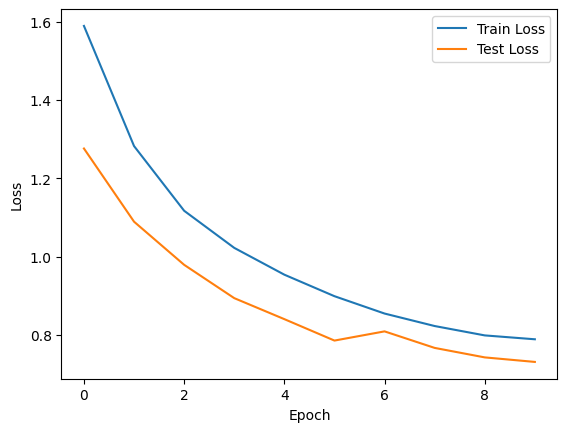

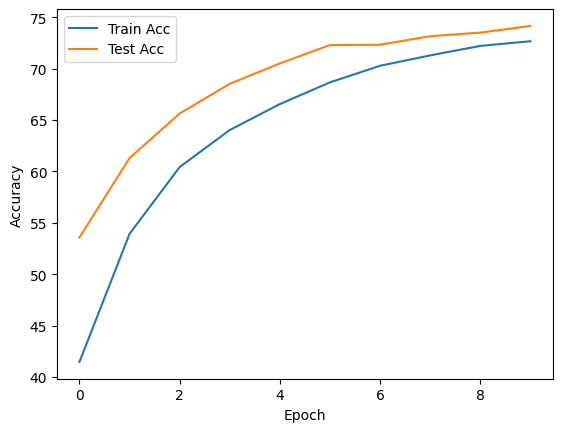

In [22]:

# define the main function
def main():
    # set the device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # set the hyperparameters
    lr = 0.001
    momentum = 0.9
    weight_decay = 5e-4
    epochs = 10
    
    # define the model, optimizer and loss function
    model = SimpleCNN().to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Define the learning rate scheduler
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0, last_epoch=-1)

    print(f"Number of model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f} million")
    print(f"Running on: {device}")
    # train the model
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        start_time = time.time()
        train_loss, train_acc = train(model, train_loader, optimizer, criterion,  device)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        end_time = time.time()
        lr_scheduler.step()

        print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%, LR: {:.6f}, Time: {:.2f}s'.format(epoch+1, train_loss, train_acc, test_loss, test_acc, optimizer.param_groups[0]['lr'], end_time-start_time))

    # plot the train and test losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the train and test accuracies
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()

### Hand-crafted implementation of 2D convolution

`TensorConv2d` is a hand-crafted implementation of `nn.Conv2d`. This is a test of low-level understanding of convolution. It uses `einops` as a helper library for tensor manipulation.

In [23]:
from einops import rearrange

class TensorConv2d(nn.Module):
    def __init__(self, n_features, n_filters, kernel_size):
        super().__init__()
        self.n_features = n_features
        self.kernel_size = kernel_size
        self.n_filters = n_filters
        self.kernel = nn.Parameter(torch.zeros((n_features * kernel_size * kernel_size, n_filters)))
        self.bias = nn.Parameter(torch.zeros(n_filters))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.bias, 0)
        nn.init.kaiming_uniform_(self.kernel, a=math.sqrt(5))
        
    def forward(self, x):
        k = self.kernel_size

        # make sure that kernel and bias are in the same device as x
        if self.kernel.device != x.device:
            self.kernel.to(x.device)
            self.bias.to(x.device)

        # batch, height, width
        b = x.shape[0]
        h = x.shape[2]
        w = x.shape[3]

        # making sure the feature map to be convolved is of the right size
        # and we dont go past beyond the the feature map boundary
        wk = k * (w // k) 
        hk = k * (h // k)
        wf = w % k 
        hf = h % k

        # Tensor Level Convolution
        # Basic idea: (Repeat kernel_size times per row and per col) 
        # 1) convert an image into patches
        # 2) perform convolution on each patch which is equivalent to 
        #  - dot product of each patch with the kernel plus bias term
        # 4) move 1 feature point along the horizontal axis (to be done kernel_size times)
        # 5) go to 1)
        # 6) move 1 feature point along the vertical axis (to be done kernel_size times)
        # 7) go to 1)

        # Tensor z contains the output of the convolution
        # make sure tensor z is the correct device as x
        z = torch.empty((b, self.n_filters, h-k+1, w-k+1)).to(x.device)

        for i in range(k):
            # row offset 
            # we need to perform offset k times
            hoff = i if hf >= i else (-k + i)
            for j in range(k):
                # column offset 
                # we need to perform offset k times
                woff = j if wf >= j else (-k + j)
                
                # shift i row and j col
                y = x[:, :, i: hk + hoff:, j: wk + woff:]
        
                # convert to patches (p1 p2 c)
                y = rearrange(y, "b c (h p1) (w p2) -> b h w (p1 p2 c)", p1=k, p2=k)
                # dot product plus bias term
                y = y @ self.kernel + self.bias

                # sparse feature map: channel first
                y = rearrange(y, 'b h w c -> b c h w')

                # assign the feature map to the correct position in the output tensor
                z[:,:,i::k,j::k] = y
        
        return z

## PyTorch Lightning (PL) Implementation

The following shows how PL simplifies the overall code. We use the same CNN model as above. We also use the same train and test functions. The only difference is that we use the `LightningModule` class to define the model. We also use the `Trainer` class to train the model.


PL has built-in support for `accuracy` measurement (`torchmetrics`) and logging (`default`, `tensorboard` and `wandb`). We can also use `torchvision` to download the CIFAR10 dataset.

In [33]:
import lightning as L
import torchmetrics

class LSimpleCNN(L.LightningModule):
    def __init__(self, n_features=3, kernel_size=3, n_filters=32, num_classes=10, conv2d=nn.Conv2d) -> None:
        super().__init__()
        self.model = SimpleCNN(n_features, kernel_size, n_filters, num_classes, conv2d)
        self.epochs = 10
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_losses = []
        self.train_acc = []
        self.val_acc = []
        self.val_losses = []
        
    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.train_losses.append(loss)
        acc = self.accuracy(y_hat, y)
        self.train_acc.append(acc)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return { "loss": loss, "acc": acc }
    
    def on_train_epoch_start(self):
        self.train_losses.clear()
    
    def on_train_epoch_end(self):
        self.log("lr", self.optimizer.param_groups[0]['lr'], on_epoch=True, prog_bar=True, logger=True)

    def on_test_epoch_start(self) -> None:
        return self.on_validation_epoch_start()

    def on_validation_epoch_start(self) -> None:
        self.val_acc.clear()
        self.val_losses.clear()
        
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.val_acc.append(acc)
        self.val_losses.append(loss)
        return {"test_loss": loss, "test_acc": acc}
    
    def on_test_epoch_end(self) -> None:
        return self.on_validation_epoch_end()
    
    def on_validation_epoch_end(self):
        avg_acc = torch.stack([x for x in self.val_acc]).mean()
        avg_loss = torch.stack([x for x in self.val_losses]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", avg_acc, on_epoch=True, prog_bar=True, logger=True)
    
    def configure_optimizers(self):
        self.optimizer = Adam(self.parameters(), lr=0.001, weight_decay=5e-4)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=self.epochs, eta_min=0, last_epoch=-1)
        
        return [self.optimizer], [self.scheduler]
    

### Model creation, training and testing

Using PL, model creation, training and testing is simplified. We can also use `Trainer` to log the model metrics to `tensorboard` and `wandb`. For this example, we will just print the results on the screen.

In [37]:
model = LSimpleCNN()

trainer = L.Trainer(max_epochs=10, devices=1, accelerator="gpu",)
trainer.fit(model, train_loader, test_loader)
trainer.test(model, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | SimpleCNN          | 113 K 
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.455     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 9: 100%|██████████| 782/782 [00:11<00:00, 66.43it/s, v_num=6, train_acc_step=0.938, train_loss_step=0.313, test_loss=0.717, test_acc=0.753, train_acc_epoch=0.734, train_loss_epoch=0.764, lr=2.45e-5] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 782/782 [00:11<00:00, 66.34it/s, v_num=6, train_acc_step=0.938, train_loss_step=0.313, test_loss=0.717, test_acc=0.753, train_acc_epoch=0.734, train_loss_epoch=0.764, lr=2.45e-5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 138.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7527866363525391     │
│         test_loss         │    0.7170971632003784     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7170971632003784, 'test_acc': 0.7527866363525391}]

### PL `LightningDataModule`

PL has a built-in `LightningDataModule` class that can be used to create the train and test data loaders. We can also use `torchvision` to download the CIFAR10 dataset.

This simplifies the overall management of datasets and dataloaders.

In [38]:
class LDataModule(L.LightningDataModule):
    def __init__(self, batch_size=64) -> None:
        super().__init__()
        self.batch_size = batch_size
        
    def prepare_data(self):
        # download
        torchvision.datasets.CIFAR10(root='~/data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='~/data', train=False, download=True)
        
    def setup(self, stage=None):
        # transform
        transform_train = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        transform_test = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        # split
        self.trainset = torchvision.datasets.CIFAR10(root='~/data', train=True, 
                                                     download=False, 
                                                     transform=transform_train)
        self.testset = torchvision.datasets.CIFAR10(root='~/data', train=False, 
                                                    download=False, 
                                                    transform=transform_test)
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.trainset, 
                                           batch_size=self.batch_size, 
                                           shuffle=True, num_workers=2)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.testset, 
                                           batch_size=self.batch_size, 
                                           shuffle=False, num_workers=2)
    
    def test_dataloader(self):
        return self.val_dataloader()

In [39]:
loader = LDataModule()
trainer.fit(model, loader)
trainer.test(model, dataloaders=loader)

Files already downloaded and verified
Files already downloaded and verified


/home/rowel/anaconda3/envs/speech/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory /home/rowel/github/roatienza/Deep-Learning-Experiments/versions/2023/cnn/demo/lightning_logs/version_6/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | SimpleCNN          | 113 K 
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.455     Total estimated model params size (MB)


`Trainer.fit` stopped: `max_epochs=10` reached.


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 139.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7527866363525391     │
│         test_loss         │    0.7170971632003784     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7170971632003784, 'test_acc': 0.7527866363525391}]